# Energy price prediction in the Spanish day-ahead market

## 1. Introduction
The objective of this project is to forecast spot electricity prices in the Spanish day-ahead market. In electricity markets, suppliers and consumers submit their bids and offers for each trading hour (newly for each 15 min slots but this projects uses data with 1 hour slots).
Based on these submissions, the market operator constructs aggregated bidding curves, 
the intersection of supply and demand determines the market clearing price of electricity for the following day and hour.

Predicting these prices is a supervised regression problem, this notebook details the machine learning pipeline used to predict the target variable `price day ahead` (€/MWh) using linear regression and ARIMA residuals correction.

## 2. Problem Formulation
We represent the dataset as a matrix $X \in \mathbb{R}^{M \times N}$, where $M$ is the number of hourly samples and $N$ is the number of features. The goal is to learn a mapping function $f(X) \to y$ that minimizes the mean squared error (MSE).

### Dataset Source
The data corresponds to hourly observations from the Spanish electricity market (Kaggle), covering generation (fossil, wind, hydro), demand, and weather data.

To correctly model the day-ahead market (DAM), we must respect the time order of the features in our dataset.

### Trading timeline
* The auction for electricity delivery for tomorrow (Day D) takes place today (Day D-1), typically closing around 12:00 CET.
* At the moment we submit our bid, we do not know the actual generation or consumption for tomorrow. We only have forecasts and historical data from yesterday/today.

### Feature alignment
To simulate a real-world environment, we categorize features based on their availability at given timestep:

| Feature Type | Description | Action |
| :--- | :--- | :--- |
| **Forecasts** <br>*(Load, Wind, Solar)* | Published by the TSO before the auction. These are estimates for the target hour $t$. |  **No Shift** <br> Use values at time $t$. |
| **Actuals** <br>*(Generation, Load)* | Measured in real-time. The value for time $t$ is unknown at the time of bidding. |  **Lag (Shift) by 24h** <br> Use values from $t-24$ (yesterday's reality). |







In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from tqdm import tqdm  


# load the data
df = pd.read_csv('energy_dataset.csv')
df['time'] = pd.to_datetime(df['time'], utc=True)
df = df.set_index('time')

original_shape = df.shape
# Identify and drop sparse columns (columns with > 50% missing values)
missing_ratio = df.isnull().mean()
cols_to_drop_sparse = missing_ratio[missing_ratio > 0.5].index.tolist()
print(f"Dropping sparse columns: {cols_to_drop_sparse}")
df = df.drop(columns=cols_to_drop_sparse)

# Identify columns to shift (generation + load actual)
cols_generation = [c for c in df.columns if 'generation' in c]
col_load_actual = 'total load actual' if 'total load actual' in df.columns else None
cols_to_shift = cols_generation
if col_load_actual:
    cols_to_shift.append(col_load_actual)

# perform shift
df[cols_to_shift] = df[cols_to_shift].shift(24)

# drop 'price actual'
if 'price actual' in df.columns:
    df = df.drop(columns=['price actual'])

# drop remaining nans after shifting
df_clean = df.dropna()

print(f"\nShape original: {original_shape}") 
print(f"Shape after cleaning: {df_clean.shape}")

print("Following columns were shifted by 24 hours (lagged):")
print(cols_to_shift)

df_clean.head()

Dropping sparse columns: ['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead']

Shape original: (35064, 28)
Shape after cleaning: (34993, 25)
Following columns were shifted by 24 hours (lagged):
['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'total load actual']


,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,...,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,863.0,...,73.0,49.0,196.0,0.0,6378.0,5.0,13329.0,27309.0,25385.0,10.0
2015-01-02 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,920.0,...,71.0,50.0,195.0,0.0,5890.0,35.0,12718.0,25397.0,24382.0,7.0
2015-01-02 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,1164.0,...,73.0,50.0,196.0,0.0,5461.0,43.0,12375.0,23640.0,22734.0,5.0
2015-01-02 02:00:00+00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,1503.0,...,75.0,50.0,191.0,0.0,5238.0,32.0,11524.0,22638.0,21286.0,4.0
2015-01-02 03:00:00+00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,1826.0,...,74.0,42.0,189.0,0.0,4935.0,31.0,11310.0,22238.0,20264.0,4.0


## 3. Feature engineering and selection

Electricity prices are time-dependent. To capture these dynamics, we have used two types of features:
1.  **Time-related features:** `day of week`, `hour of day`, and `month`.
2.  **Moving Statistics:** Rolling averages (SMA) and standard deviations (STD) with windows of 9,12,24 hours.

### 3.1 Feature creation of time related features

Time-related features such as hour of day and month are cyclical:
hour 23 is followed by hour 0, but their numerical values are far apart.

If encoded as integers (0–23), machine learning models would interpret
the distance between 23 and 0 as large, which is incorrect in a temporal sense.

To account for this cyclical nature, we encode the hours and months using
sine and cosine transformations to map them onto the unit circle.

For the hour of day:

$$
\text{hour}_{\sin} = \sin\left(\frac{2\pi \cdot \text{hour}}{24}\right), \quad
\text{hour}_{\cos} = \cos\left(\frac{2\pi \cdot \text{hour}}{24}\right)
$$

For the month of year:

$$
\text{month}_{\sin} = \sin\left(\frac{2\pi \cdot \text{month}}{12}\right), \quad
\text{month}_{\cos} = \cos\left(\frac{2\pi \cdot \text{month}}{12}\right)
$$

So now we should have smooth transitions across daily and yearly
boundaries which allows models to capture both hourly and seasonal patterns.


In [2]:
def encode_cyclical_time_features(df):
    df = df.copy()
    
    # Hour of day (0–23)
    df["hour_sin"] = np.sin(2 * np.pi * df.index.hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df.index.hour / 24)
    df["hour"] = df.index.hour  
    
    # Month of year (1–12)
    df["month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
    df["month_cos"] = np.cos(2 * np.pi * df.index.month / 12)
    df["month"] = df.index.month
    df['weekday'] = df.index.weekday

    return df

# Encode cyclical time features
data = encode_cyclical_time_features(df_clean)
data[["hour_sin", "hour_cos", "month_sin", "month_cos"]].head()


,hour_sin,hour_cos,month_sin,month_cos
time,,,,
2015-01-01 23:00:00+00:00,-0.258819,0.965926,0.5,0.866025
2015-01-02 00:00:00+00:00,0.000000,1.000000,0.5,0.866025
2015-01-02 01:00:00+00:00,0.258819,0.965926,0.5,0.866025
2015-01-02 02:00:00+00:00,0.500000,0.866025,0.5,0.866025
2015-01-02 03:00:00+00:00,0.707107,0.707107,0.5,0.866025


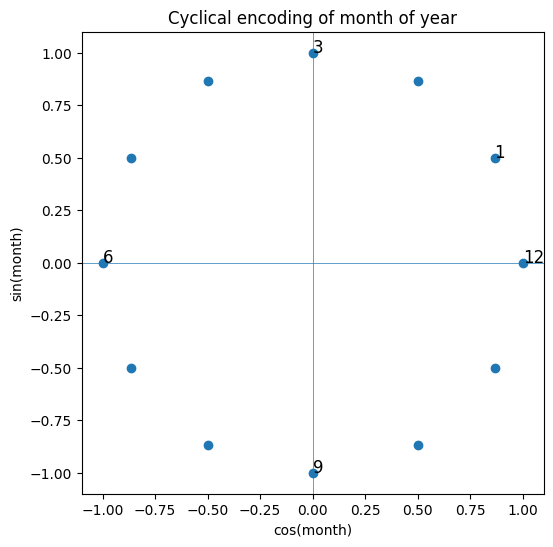

In [3]:
#small visualization demo of the enconding
months = np.arange(1, 13)

month_sin = np.sin(2 * np.pi * months / 12)
month_cos = np.cos(2 * np.pi * months / 12)

plt.figure(figsize=(6,6))
plt.scatter(month_cos, month_sin)

for m in [1, 3, 6, 9, 12]:
    plt.text(month_cos[m-1], month_sin[m-1], f"{m}", fontsize=12)

plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.xlabel("cos(month)")
plt.ylabel("sin(month)")
plt.title("Cyclical encoding of month of year")
plt.gca().set_aspect("equal")
plt.show()


## 3.2 Feature selection

1. To avoid any data leakage, I first split the data to training and testing sets in 80:20 ratio.
2. Initial feature selection is applied only to raw input variables, based on
   their absolute correlation with the target variable. (features with correlation $| \rho | < 0.25$ were discarded)
3. Rolling statistics (SMA, STD) are computed only for the selected raw
   variables.
4. Step 2 is repeated.
5. We calculate the correlation matrix on the selected features and discard one feature from the pair if the correlation is higher than 0.7


### 3.2.1 Data splitting

In [4]:
# train/val/test split 
def split_data(X, y, train_ratio=0.8):
    n = len(X)
    n_train = int(train_ratio * n)

    X_train = X[:n_train]
    y_train = y[:n_train]

    X_test = X[n_train:]
    y_test = y[n_train:]

    return X_train, X_test, y_train, y_test

target = 'price day ahead'
y = data[target]
#remove the target from the features
x = data.drop(columns=[target])
#split the data
X_train, X_test, y_train, y_test = split_data(x, y)


### 3.2.2 Feature selection

In [5]:
def select_features(X, y, threshold=0.25):
    """
    Selects features from X based on correlation with target vector y.
    """
    # ensure y is a series
    if not isinstance(y, pd.Series):
        y = pd.Series(y, index=X.index, name='target')

    # select only numeric data from features
    numeric_X = X.select_dtypes(include=np.number)

    # calculate correlation of every column in X with y
    correlations = numeric_X.corrwith(y)

    # organize results
    df_corr = (
        correlations
        .abs()
        .rename("abs_corr")
        .to_frame()
        .join(correlations.rename("corr"))
        .sort_values("abs_corr", ascending=False)
    )

    # filter by threshold
    df_corr = df_corr[df_corr["abs_corr"] > threshold]

    return df_corr[["corr"]]


selected_features = select_features(X_train, y_train)
selected_features

c:\Users\janma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\janma\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr
generation fossil hard coal,0.520765
total load forecast,0.509059
generation fossil brown coal/lignite,0.473798
generation fossil gas,0.456467
forecast wind onshore day ahead,-0.412104
generation hydro run-of-river and poundage,-0.391709
generation hydro pumped storage consumption,-0.359895
total load actual,0.324387
generation waste,0.281444


### 3.2.3 Rolling statistics
I compute rolling standard moving averages and standard deviations for time windows [3,12,24]

In [6]:
#get the channels names
selected_features_names = selected_features.index.tolist()

X_train = X_train[selected_features_names]
X_test = X_test[selected_features_names]

def add_SMA_STD(data,channels,windows):
    data = data.copy()
    
    for ch in channels:
        for lookback in windows:
            if ch in data.columns:  
                data[f'{ch} SMA {lookback}'] = data[ch].rolling(window=lookback).mean()
                data[f'{ch} STD {lookback}'] = data[ch].rolling(window=lookback).std()
            else:
                raise ValueError(f"Column '{ch}' not found in DataFrame")

    return data

windows = [3,12,24]
X_train = add_SMA_STD(X_train, selected_features_names, windows)
X_test = add_SMA_STD(X_test, selected_features_names, windows)

#drop NA
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Verify shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train.head()

X_train shape: (27971, 63)
X_test shape: (6976, 63)


,generation fossil hard coal,total load forecast,generation fossil brown coal/lignite,generation fossil gas,forecast wind onshore day ahead,generation hydro run-of-river and poundage,generation hydro pumped storage consumption,total load actual,generation waste,generation fossil hard coal SMA 3,...,total load actual SMA 12,total load actual STD 12,total load actual SMA 24,total load actual STD 24,generation waste SMA 3,generation waste STD 3,generation waste SMA 12,generation waste STD 12,generation waste SMA 24,generation waste STD 24
time,,,,,,,,,,,,,,,,,,,,,
2015-01-02 22:00:00+00:00,4942.0,30052.0,320.0,4685.0,9560.0,1095.0,0.0,26798.0,209.0,4991.666667,...,26054.250000,2392.383373,23896.750000,3050.173969,210.333333,1.527525,209.666667,1.154701,202.166667,8.854705
2015-01-02 23:00:00+00:00,1291.0,26323.0,0.0,3189.0,9313.0,1268.0,1290.0,27070.0,169.0,3741.000000,...,26299.000000,2327.312066,23966.958333,3104.822581,196.000000,23.388031,206.333333,11.811653,201.041667,11.102210
2015-01-03 00:00:00+00:00,1190.0,24301.0,0.0,2902.0,9215.0,1263.0,1996.0,24935.0,167.0,2474.333333,...,26317.500000,2314.405264,23990.000000,3110.084145,181.666667,23.692474,202.750000,16.276726,199.875000,13.062767
2015-01-03 01:00:00+00:00,1023.0,22651.0,0.0,2772.0,9196.0,1246.0,2698.0,23214.0,167.0,1168.000000,...,26196.000000,2443.322700,24010.000000,3103.191751,167.666667,1.154701,199.166667,19.035055,198.666667,14.678190
2015-01-03 02:00:00+00:00,1016.0,21785.0,0.0,2936.0,9502.0,1248.0,3269.0,22540.0,181.0,1076.333333,...,26113.666667,2555.472749,24062.250000,3065.662426,171.666667,8.082904,196.750000,19.372544,198.250000,15.042693


Now we have 63 features, to reduce overfitting and model complexity let's filter them once again with the correlation to the target variable.
Then we account for correlation between the features

In [7]:
selected_features = select_features(X_train, y_train)
X_train_sorted = X_train[selected_features.index.tolist()]
print(f"Number of selected features: {len(selected_features)}")
selected_features


Number of selected features: 31


,corr
generation fossil hard coal,0.521806
total load forecast,0.509448
generation fossil hard coal SMA 3,0.508989
generation fossil brown coal/lignite,0.473927
total load forecast SMA 3,0.471834
generation fossil brown coal/lignite SMA 3,0.467016
generation fossil gas,0.456579
generation fossil gas SMA 3,0.445531
generation fossil hard coal SMA 12,0.443539
generation hydro run-of-river and poundage SMA 12,-0.432114


Now we account for the multicorelation between the features and plot the final correlation matrix

In [8]:
def remove_collinear_features(X, threshold=0.7):
    """
    Removes features from X that are highly correlated with each other.
    Assumes X columns are sorted by importance (best features first).
    """
    # calculate the correlation matrix (absolute values)
    corr_matrix = X.corr().abs()

    # Select the upper triangle of the correlation matrix
    # k=1 excludes the diagonal (self-correlation is always 1)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns to drop: any column having a correlation > threshold
    # with a preceding column (one to its left)
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop the features
    X_reduced = X.drop(columns=to_drop)

    return X_reduced, to_drop

# remove collinear features
X_train_final, dropped_features = remove_collinear_features(X_train_sorted, threshold=0.7)

# sync X_test to match the final selection
X_test_final = X_test[X_train_final.columns]

print(f"Dropped {len(dropped_features)} features: {dropped_features}")
print(f"Remaining features: {X_train_final.shape[1]}")


Dropped 23 features: ['generation fossil hard coal SMA 3', 'generation fossil brown coal/lignite', 'total load forecast SMA 3', 'generation fossil brown coal/lignite SMA 3', 'generation fossil gas SMA 3', 'generation fossil hard coal SMA 12', 'generation fossil brown coal/lignite SMA 12', 'generation hydro run-of-river and poundage SMA 24', 'generation fossil hard coal SMA 24', 'generation fossil brown coal/lignite SMA 24', 'forecast wind onshore day ahead SMA 3', 'generation hydro run-of-river and poundage SMA 3', 'generation hydro run-of-river and poundage', 'forecast wind onshore day ahead SMA 12', 'forecast wind onshore day ahead SMA 24', 'generation fossil gas SMA 12', 'generation hydro pumped storage consumption SMA 3', 'generation fossil gas SMA 24', 'total load actual', 'total load actual SMA 3', 'generation waste SMA 3', 'generation waste SMA 24', 'generation waste SMA 12']
Remaining features: 8


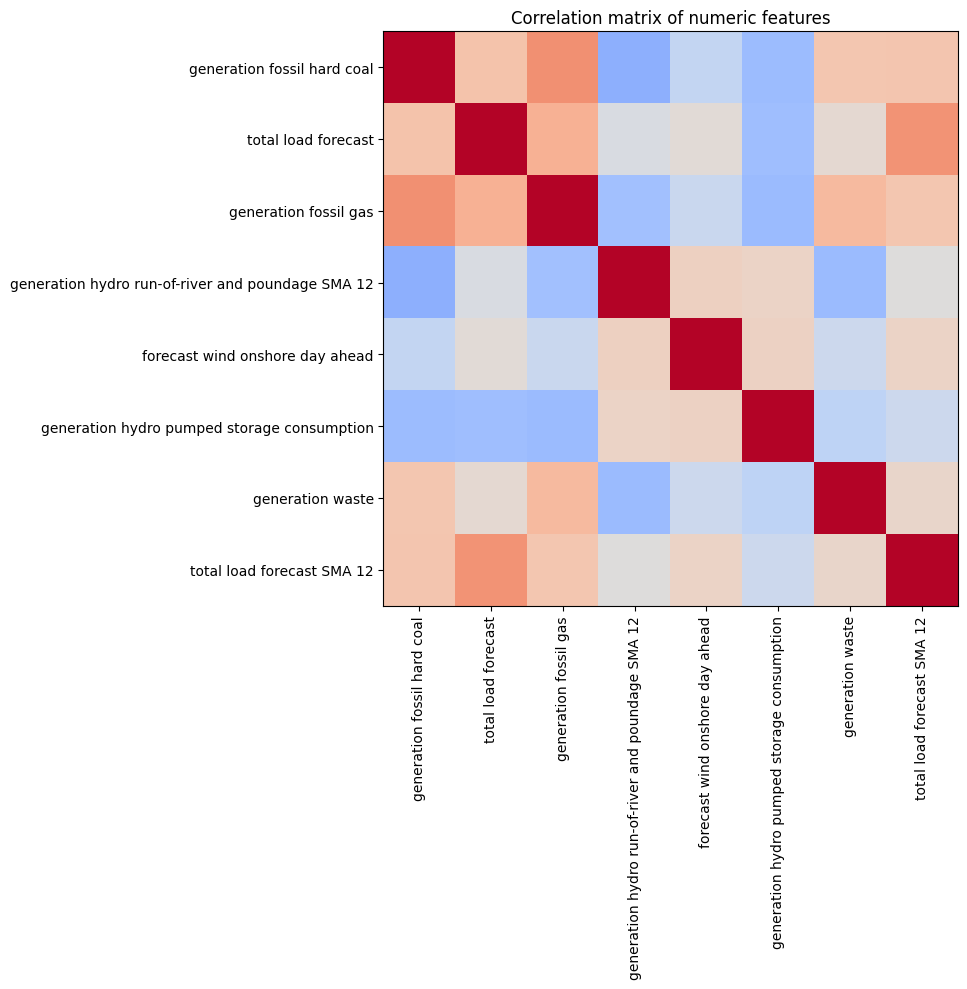

In [9]:
def plot_correlation_matrix(data):
    # only numeric columns
    numeric_data = data.select_dtypes(include=np.number)

    # correlation matrix
    corr_matrix = numeric_data.corr()
    plt.figure(figsize=(12,10))
    plt.imshow(corr_matrix.to_numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    
    plt.xticks(ticks=np.arange(len(corr_matrix)), labels=corr_matrix.columns, rotation=90)
    plt.yticks(ticks=np.arange(len(corr_matrix)), labels=corr_matrix.index)

    plt.title("Correlation matrix of numeric features")
    plt.tight_layout()
    plt.show()
    
plot_correlation_matrix(X_train_final)

# Homoscedasticity

Before building any predictive models, let's check properties of the target variable: Day ahead price.

A key assumption of standard regression models (like OLS) is *Homoscedasticity*—the assumption that the variance (volatility) of errors is constant over time. However, markets often exhibit *Heteroscedasticity*, where periods of calm are followed by periods of extreme volatility (e.g., due to geopolitical events etc...).

*Hypothesis:* The variance of electricity prices is NOT constant.
*Implication:* If proven, a global model trained on the entire history (expanding window) won't be optimal. We would need an adaptive approach (rolling window) to capture the changing market regimes.

Below, we perform the *Breusch-Pagan test* and visualize the *Rolling standard deviation* to confirm this behavior.

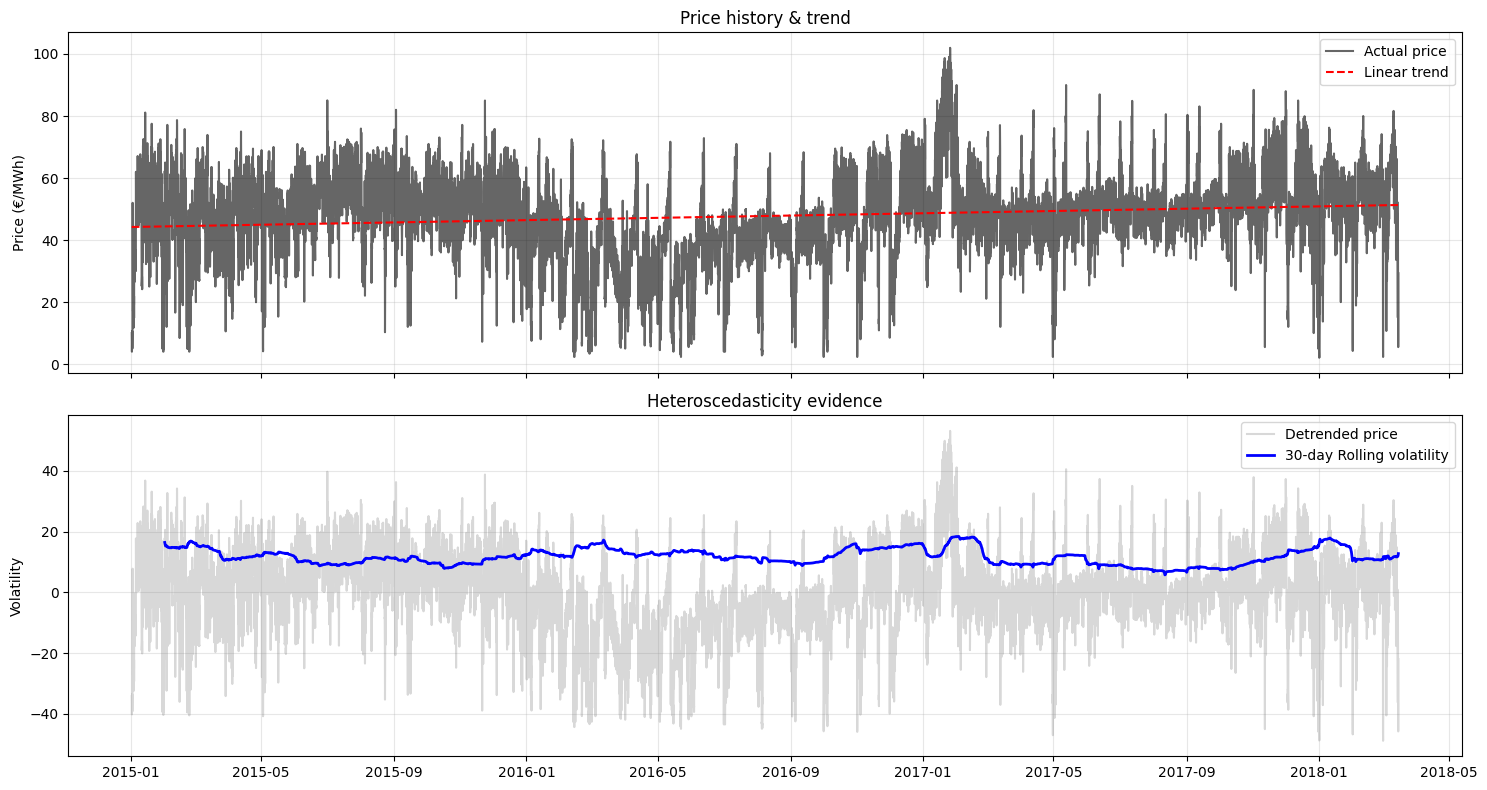

Breusch-Pagan test p-value: 8.5411e-25
Strong evidence of heteroscedasticity, volatility changes over time.


In [10]:

target_col = 'price day ahead' 

X_time = np.arange(len(y_train)).reshape(-1, 1)

#detrending
# to see the volatility, we must subtract the longterm trend
# we do this by fitting a dummy linear regression on the target variable data
model_dummy = LinearRegression()
model_dummy.fit(X_time, y_train)
trend = model_dummy.predict(X_time)


residuals_raw = y_train - trend

# visualisation of volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# price and trend
ax1.plot(y_train.index, y_train, color='black', alpha=0.6, label='Actual price')
ax1.plot(y_train.index, trend, color='red', linestyle='--', label='Linear trend')
ax1.set_title('Price history & trend')
ax1.set_ylabel('Price (€/MWh)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Rolling standard deviation
rolling_volatility = residuals_raw.rolling(window=24*30).std()

ax2.plot(y_train.index, residuals_raw, color='gray', alpha=0.3, label='Detrended price')
ax2.plot(y_train.index, rolling_volatility, color='blue', linewidth=2, label='30-day Rolling volatility')
ax2.set_title('Heteroscedasticity evidence')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# statistic test Breusch-Pagan ---
# we add constant to the test
X_with_const = sm.add_constant(X_time)

# Test
lm, p_lm, fvalue, p_fvalue = het_breuschpagan(residuals_raw, X_with_const)


print(f"Breusch-Pagan test p-value: {p_lm:.4e}")
if p_lm < 0.05:
    print("Strong evidence of heteroscedasticity, volatility changes over time.")
else:
    print("Variance appears constant.")

## 4. Linear regression
### 4.1 Walk forward validation 

As we have seen, the target variable properties change with time, so we have used rolling window walk forward validation. The model does not learn on all the past, rather only the section of the past which is reasonable for the prediction.

### Methodology
The model is trained on a fixed historical window and tested on the immediately following **24 hour** "future" window. 

After each prediction, the window slides forward by one day, the oldest day of data is dropped, and the model is retrained.

**Rolling window (3 days)**
| Iteration | Day $t-3$ | Day $t-2$ | Day $t-1$ | **Day $t$ (forecast)** | Day $t+1$ |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **1** | **TRAIN** | **TRAIN** | **TRAIN** | <span style="color:red">**TEST (24h)**</span> | |
| **2** | | **TRAIN** | **TRAIN** | **TRAIN** | <span style="color:red">**TEST (24h)**</span> |
| **3** | | | **TRAIN** | **TRAIN** | **TRAIN** | ... |


### Data scaling and imputing
To prevent data leakage, scaling is performed within each validation step:

1. **Fit**: For each specific training segment, the data characteristics (mean, variance) are learnt using `.fit()` only on that window.
2. **Transform**: Using these specific characteristics, we scale:
    * The current training segment.
    * The specific 24-hour testing segment immediately following it.

This ensures that the scaler for any given day is derived only from the data available up to that point. Consequently, for $N$ days of forecasting, we compute $N$ distinct scaling transformations.

For the optimal training period we run a grid search and compare the results.
### 4.2 Model fit and evaluation

Total number of samples: 27971
Validation starts at index: 17520
Number of validation days: 435
Testing lookback window: 2 weeks (336 hours)...


100%|██████████| 435/435 [00:12<00:00, 33.67it/s]


 -> Average RMSE: 7.5789 €/MWh
Testing lookback window: 1 Month (720 hours)...


100%|██████████| 435/435 [00:11<00:00, 38.42it/s]


 -> Average RMSE: 6.8633 €/MWh
Testing lookback window: 3 Months (2160 hours)...


100%|██████████| 435/435 [00:05<00:00, 75.92it/s] 


 -> Average RMSE: 7.2385 €/MWh
Testing lookback window: 6 Months (4320 hours)...


100%|██████████| 435/435 [00:01<00:00, 266.57it/s]


 -> Average RMSE: 8.3197 €/MWh
Testing lookback window: 1 Year (8760 hours)...


100%|██████████| 435/435 [00:01<00:00, 250.92it/s]


 -> Average RMSE: 8.6629 €/MWh
Testing lookback window: 2 Years (17520 hours)...


100%|██████████| 435/435 [00:03<00:00, 116.62it/s]


 -> Average RMSE: 9.1375 €/MWh


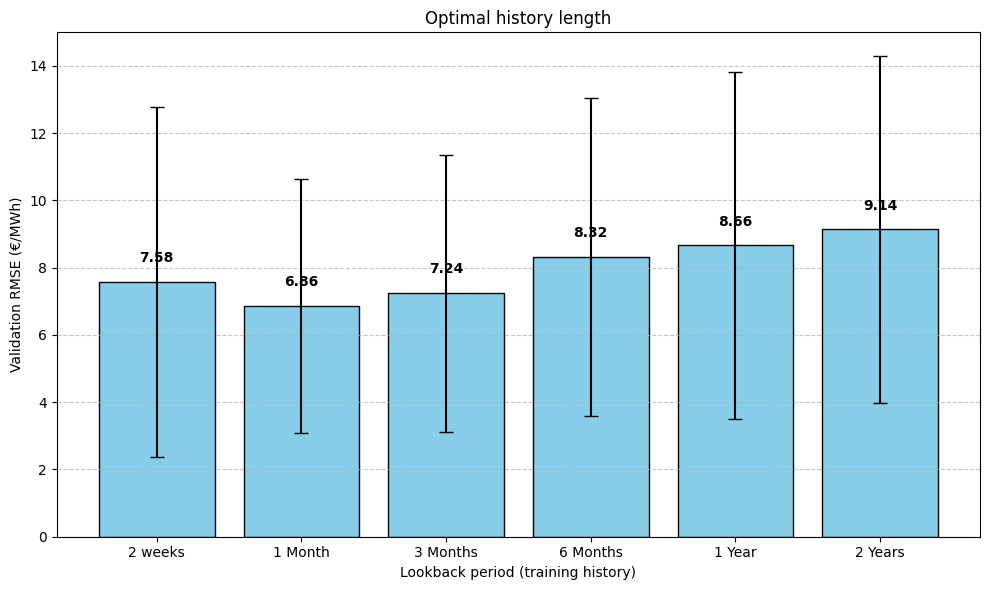

In [11]:

# 1. just to make sure y is aligned with X after dropping some nan values
common_index = X_train_final.index.intersection(y_train.index)
X_aligned = X_train_final.loc[common_index]
y_aligned = y_train.loc[common_index]

# transfer to numpy for speed
X_values = X_aligned.values
y_values = y_aligned.values

print(f"Total number of samples: {len(X_values)}")

# 2. Definition of lookback windows in hours
windows = {
    '2 weeks' : 14 * 24,
    '1 Month': 30 * 24,
    '3 Months': 90 * 24,
    '6 Months': 180 * 24,
    '1 Year': 365 * 24,
    '2 Years': 2 * 365 * 24
}


horizon = 24  # we predict only one day ahead
max_lookback = max(windows.values()) 

# Aby bylo srovnání fér, musíme začít testovat až tam, kde má i největší okno dost dat
start_validation_idx = max_lookback 
n_test_samples = len(X_values) - start_validation_idx
steps = n_test_samples // horizon

print(f"Validation starts at index: {start_validation_idx}")
print(f"Number of validation days: {steps}")

results = {
    'window_name': [],
    'avg_rmse': [],
    'std_rmse': []
}

#looping through lookback windows
for w_name, w_size in windows.items():
    print(f"Testing lookback window: {w_name} ({w_size} hours)...")
    
    rmses = []
    
    # rolling window loop
    for i in tqdm(range(steps)):
        
        
        # end of training = start of validation + prediction horizon
        current_train_end = start_validation_idx + (i * horizon)
        
        # beginning of training = end - lookback
        current_train_start = current_train_end - w_size
        
    
        current_test_end = current_train_end + horizon
        
        # if we extend X_values len
        if current_test_end > len(X_values):
            break
            
        # Slicing
        X_tr = X_values[current_train_start : current_train_end]
        y_tr = y_values[current_train_start : current_train_end]
        
        X_val = X_values[current_train_end : current_test_end]
        y_val = y_values[current_train_end : current_test_end]
        
    
        # Impute and scale
        imputer = SimpleImputer(strategy='mean')
        scaler = StandardScaler()
        
        # Fit on rolling train
        X_tr_sc = scaler.fit_transform(imputer.fit_transform(X_tr))
        # Transform validation
        X_val_sc = scaler.transform(imputer.transform(X_val))
        
        # Model
        model = LinearRegression()
        model.fit(X_tr_sc, y_tr)
        
        # Predict and eval
        y_pred = model.predict(X_val_sc)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    # results
    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    
    results['window_name'].append(w_name)
    results['avg_rmse'].append(mean_rmse)
    results['std_rmse'].append(std_rmse)
    
    print(f" -> Average RMSE: {mean_rmse:.4f} €/MWh")

# plotting
plt.figure(figsize=(10, 6))


bars = plt.bar(results['window_name'], results['avg_rmse'], 
               yerr=results['std_rmse'], capsize=5, color='skyblue', edgecolor='black')

plt.xlabel('Lookback period (training history)')
plt.ylabel('Validation RMSE (€/MWh)')
plt.title('Optimal history length')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

#### Based on this graph we will use 3 months as a training history for our model
And run the model once again to plot the results


In [12]:

lookback = 720
horizon = 24

start_validation_idx = 720
n_test_samples = len(X_values) - start_validation_idx
steps = n_test_samples // horizon

print(f"Validation starts on index: {start_validation_idx}")
print(f"Number of testing days: {steps}")


y_pred_roll = []
    

for i in tqdm(range(steps)):
        

    # end of training = start of validation + prediction horizon
    current_train_end = start_validation_idx + (i * horizon)
        
     # beginning of training = end - lookback
    current_train_start = current_train_end - lookback
        
    current_test_end = current_train_end + horizon
        
   # if we extend X_values len
    if current_test_end > len(X_values):
        break
        
    # Slicing 
    X_tr = X_values[current_train_start : current_train_end]
    y_tr = y_values[current_train_start : current_train_end]
        
    X_val = X_values[current_train_end : current_test_end]
    y_val = y_values[current_train_end : current_test_end]
        

    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
        
    # Fit on rolling train
    X_tr_sc = scaler.fit_transform(imputer.fit_transform(X_tr))
    # Transform validation
    X_val_sc = scaler.transform(imputer.transform(X_val))
        
    #  Model
    model = LinearRegression()
    model.fit(X_tr_sc, y_tr)
        
    # Predict and eval
    y_pred = model.predict(X_val_sc)
    y_pred_roll.extend(y_pred)
   


Validation starts on index: 720
Number of testing days: 1135


100%|██████████| 1135/1135 [00:02<00:00, 490.55it/s]


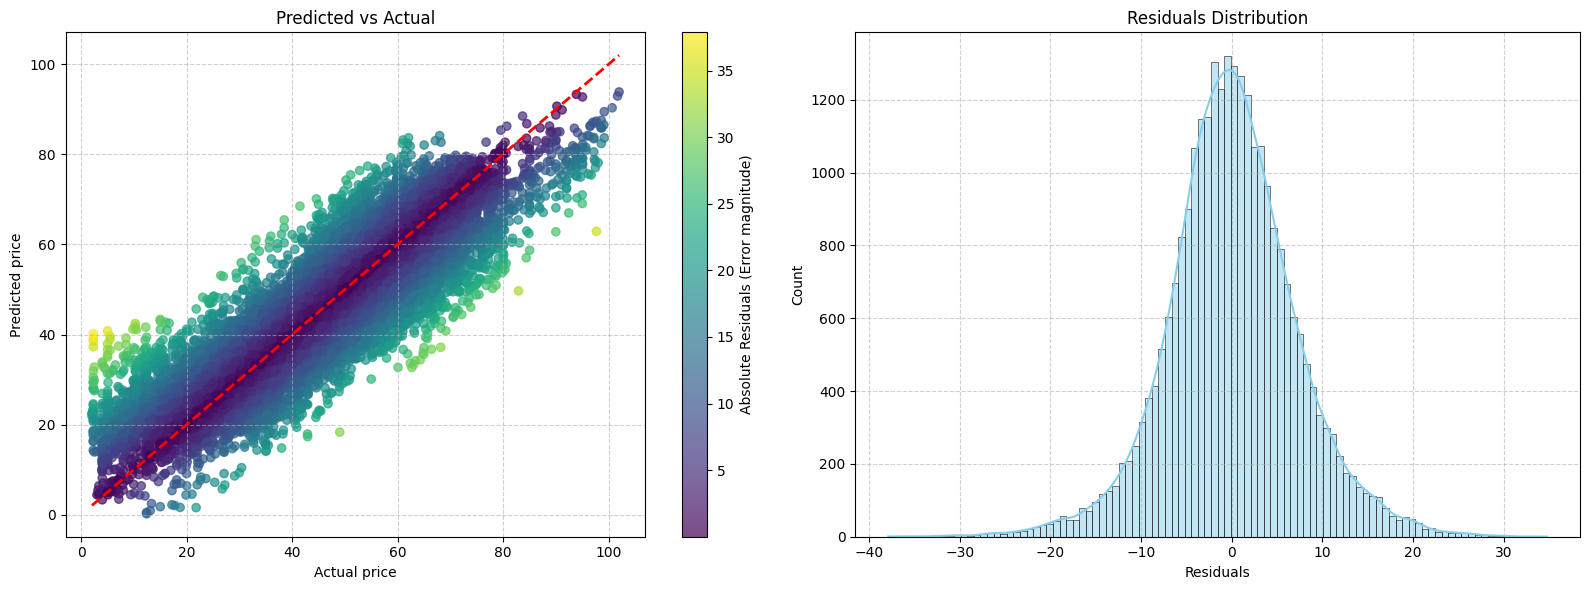

In [13]:

def plot_test_results(y_test, y_test_pred):
    # residulas
    residuals = y_test - y_test_pred
   
    abs_residuals = np.abs(residuals)

    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Predicted vs actual 
    
    sc = axes[0].scatter(y_test, y_test_pred, c=abs_residuals, cmap='viridis', alpha=0.7)
    

    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

    cbar = fig.colorbar(sc, ax=axes[0])
    cbar.set_label("Absolute Residuals (Error magnitude)")
    
    axes[0].set_title("Predicted vs Actual")
    axes[0].set_xlabel("Actual price")
    axes[0].set_ylabel("Predicted price")
    axes[0].grid(True, linestyle='--', alpha=0.6)

    #  Histogram residuals

    sns.histplot(residuals, bins=100, kde=True, color='skyblue', ax=axes[1])
    axes[1].set_title("Residuals Distribution")
    axes[1].set_xlabel("Residuals")
    axes[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

plot_test_results(y_values[start_validation_idx:current_test_end], y_pred_roll)

## Residual diagnostics and ARIMA correction

Least squares linear regression assumes that **errors are independent white noise**.  
In practice, this assumption is often violated: residuals may show autocorrelation, seasonality, or non-zero mean, looking at distribution of our residuals, we can see that this is the case as well.

To account for this, we model the residuals as ARIMA model to capture the dependencies in the residuals which the linear regression model was not able to explain.

The goal is to decompose the prediction into:  
1. A deterministic component explained by regression features  
2. A stochastic component capturing temporal dependence in the residuals  

The final forecast is obtained by correcting the regression prediction with the forecasted residual component.  
After this correction, the residuals should resemble **white noise**.

### ARIMA

ARIMA stands for:

AutoRegressive  
Integrated  
Moving Average  


It is a time series model that explains a value
at given timestep using:
- its own past values (autoregresive)
- past forecast errors (moving average)
- differencing (to make the time series stationary)


### ARIMA(p, d, q)

An ARIMA model is defined by three parameters:

$$
\text{ARIMA}(p, d, q)
$$

### p — Autoregressive (AR) order
- How many past values of the series are used

$$
p = 2 \;\Rightarrow\; y_t \text{ depends on } y_{t-1}, y_{t-2}
$$

### d — Differencing order
- How many times the series is differenced
- Used to remove trend and make the series stationary
- Example:
$$
y'_t = y_t - y_{t-1}
$$


### q — Moving Average (MA) order
- How many past errors are used
- Models short-term shock propagation
- Current value depends on last period’s error


After differencing \(d\) times, ARIMA looks like:

$$
y_t =
\phi_1 y_{t-1} + \dots + \phi_p y_{t-p}
+
\theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q}
+
\varepsilon_t

$$



$
\begin{aligned}
y_t &:\ \text{differenced series} \\
\phi &:\ \text{AR coefficients} \\
\theta &:\ \text{MA coefficients} \\
\varepsilon_t &:\ \text{white noise}
\end{aligned}
$


### ACF and PACF
To determine appropriate orders for the AR and MA components, we analyze the residuals and plot the autocorrelation function (ACF), partial autocorrelation function (PACF), Q-Q plot and run a test to see if they are just a white noise.


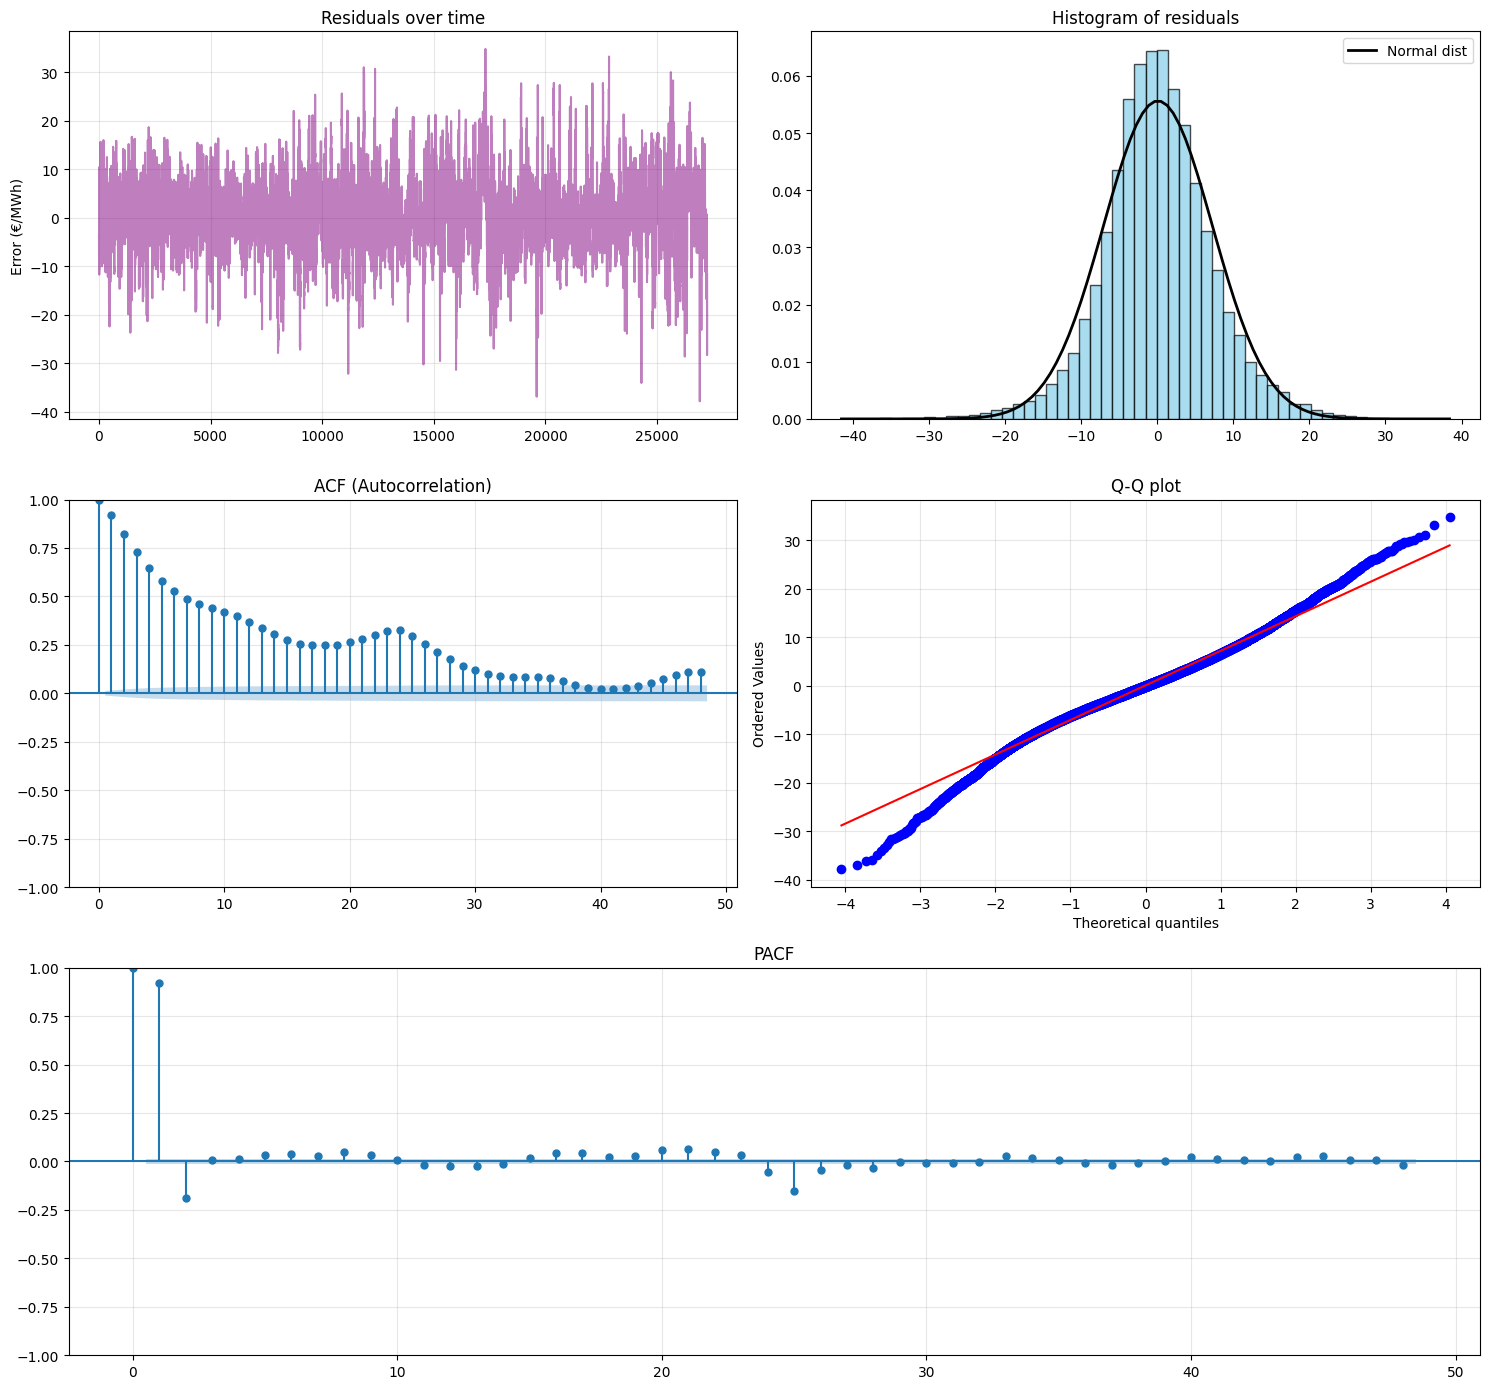


 Ljung-Box test (White noise check)
 Residuals are not white noise.


In [14]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

def analyze_residuals(y_true, y_pred):
    #residuals
    if hasattr(y_true, 'values') and hasattr(y_pred, 'values'):
        residuals = y_true - y_pred
    else:
        residuals = np.array(y_true) - np.array(y_pred)
    

    plt.figure(figsize=(15, 14))
    
    #residuals over time
    plt.subplot(3, 2, 1)
    plt.plot(residuals, color='purple', alpha=0.5)
    plt.title("Residuals over time")
    plt.ylabel("Error (€/MWh)")
    plt.grid(True, alpha=0.3)
    
    # Histogram 
    plt.subplot(3, 2, 2)
    plt.hist(residuals, bins=50, density=True, color='skyblue', edgecolor='black', alpha=0.7)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, residuals.mean(), residuals.std())
    plt.plot(x, p, 'k', linewidth=2, label='Normal dist')
    plt.title("Histogram of residuals")
    plt.legend()
    
    # ACF Plot
    ax3 = plt.subplot(3, 2, 3)
    plot_acf(residuals, lags=48, ax=ax3, alpha=0.05, title='ACF (Autocorrelation)')
    plt.grid(True, alpha=0.3)
    
    # D) Q-Q plot
    ax4 = plt.subplot(3, 2, 4)
    probplot(residuals, dist="norm", plot=ax4)
    plt.title("Q-Q plot")
    plt.grid(True, alpha=0.3)


    # E) PACF plot 
    ax5 = plt.subplot(3, 1, 3)
    plot_pacf(residuals, lags=48, ax=ax5, alpha=0.05, title='PACF', method='ywm')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # LJUNG-BOX TEST 
    lb_test = acorr_ljungbox(residuals, lags=24, return_df=True)
         
    print("\n Ljung-Box test (White noise check)")
    alpha = 0.05
    lb_test["reject_H0"] = lb_test["lb_pvalue"] < alpha
  
    if lb_test["reject_H0"].any():
        print(" Residuals are not white noise.")
    else:
        print("Residuals appear to be white noise.")


    

import scipy.stats as stats
analyze_residuals(y_values[start_validation_idx:current_test_end], y_pred_roll)

We can see slowly decaying ACF and a sharp cut-off in the
PACF after lag 2. This pattern is characteristic of an autoregressive (AR) process.

To see if the residuals series is stationary, we run Augmented Dickey–Fuller (ADF) test


In [15]:
from statsmodels.tsa.stattools import adfuller


def adf_test(series):

    # returns: test_stat, pvalue, usedlag, nobs, critical_values, icbest
    result = adfuller(series, autolag="AIC")
    print(f"ADF Test:")
    print(f"Test Statistic : {result[0]:.4f}")
    print(f"p-value        : {result[1]:.4f}")
    print("Critical Values:")
    for k, v in result[4].items():
        print(f"  {k}: {v:.4f}")
    
    if result[1] < 0.05:
        print("Series is stationary (reject H0)")
    else:
        print("Series is NOT stationary (fail to reject H0)")
adf_test(y_values[start_validation_idx:current_test_end] - y_pred_roll)



ADF Test:
Test Statistic : -18.9521
p-value        : 0.0000
Critical Values:
  1%: -3.4306
  5%: -2.8616
  10%: -2.5668
Series is stationary (reject H0)


Series is stationary, so it does not need differencing (I component) or log transform. 

Now to determine if there is any hidden seasonal patern, I plot periodogram, which computes the fast fourier transform on the residuals to extract the dominant frequencies.


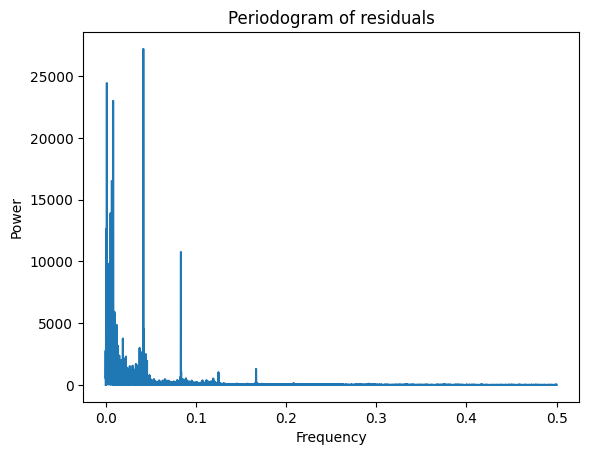

Maximum power occurs at frequency: 0.04170
Estimated period: 23.98 hours


In [16]:
from scipy.signal import periodogram
f, Pxx = periodogram(y_values[start_validation_idx:current_test_end] - y_pred_roll)
plt.plot(f, Pxx)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.title('Periodogram of residuals')
plt.show()

# find index of maximum power
idx_max = np.argmax(Pxx)
# frequecy at maximum power
freq_max = f[idx_max]

print(f"Maximum power occurs at frequency: {freq_max:.5f}")

period_hours = 1 / freq_max
print(f"Estimated period: {period_hours:.2f} hours")

We can see that major frequency that corresponds to the period 24 hours. To account for this, we model the residuals as AR process that depends on lags: [1,2,23]


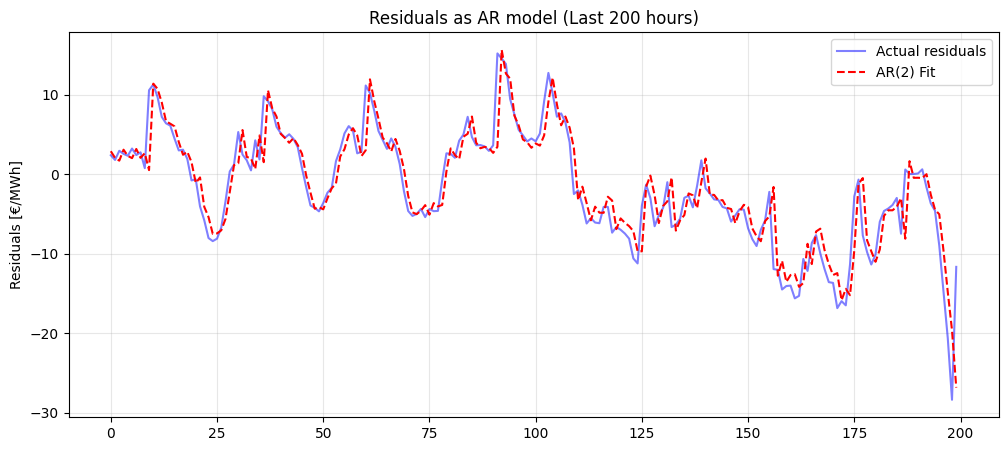

In [17]:

from statsmodels.tsa.ar_model import AutoReg

residuals = y_values[start_validation_idx:current_test_end] - y_pred_roll

#  fit AR model on residuals history
model = AutoReg(residuals, lags=[1,2,23], old_names=False)
ar_fit = model.fit()
results = model.fit()

# last 200 hours
last_n = 200
subset_res = residuals[-last_n:]
subset_fit = results.fittedvalues[-last_n:]


x_axis = subset_res.index if hasattr(subset_res, 'index') else range(last_n)

plt.figure(figsize=(12, 5))
plt.plot(x_axis, subset_res, label='Actual residuals', alpha=0.5, color='blue')
plt.plot(x_axis, subset_fit, label='AR(2) Fit', color='red', linestyle='--')

plt.title(f'Residuals as AR model (Last {last_n} hours)')
plt.ylabel('Residuals [€/MWh]')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


###  Methodology

We will repeating the same workflow as in section 4.1 but with correction to the residuals, in each validation step:

1.  **Base prediction:** We train a standard linear regression model on the features ($X$) to predict the price ($\hat{y}_{base}$).
2.  **Residual calculation:** We calculate the residuals ($e_t$) on the training set:
    $$e_t = y_{true} - \hat{y}_{base}$$
3.  **Residual modeling:** We fit the autoregressive model on these residuals. This allows the model to learn from its recent mistakes (e.g., "if I underpredicted yesterday and the day before, I will likely underpredict today").
4.  **Correction:** We forecast the expected error for the validation set ($\hat{e}_{next}$) and add it to the base prediction:
    $$\hat{y}_{final} = \hat{y}_{base} + \hat{e}_{next}$$



In [18]:
import warnings

warnings.filterwarnings("ignore")


lookback = 720
horizon = 24  # we only predict one day ahead


start_validation_idx = 720
n_test_samples = len(X_values) - start_validation_idx
steps = n_test_samples // horizon

print(f"Validation starts at index: {start_validation_idx}")
print(f"Number of test days (steps): {steps}")

y_pred_roll = []
rmse = []
rmse_ar_correction = []
#main rolling window loop
for i in tqdm(range(steps)):
    
    #index defition for current step
    current_train_end = start_validation_idx + (i * horizon)
    current_train_start = current_train_end - lookback
    current_test_end = current_train_end + horizon
    
    
    if current_test_end > len(X_values):
        break
            
    # slicing 
    X_tr = X_values[current_train_start : current_train_end]
    y_tr = y_values[current_train_start : current_train_end]
        
    X_val = X_values[current_train_end : current_test_end]
    y_val = y_values[current_train_end : current_test_end]
        

    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
        
    # Fit on rolling train
    X_tr_sc = scaler.fit_transform(imputer.fit_transform(X_tr))
    X_val_sc = scaler.transform(imputer.transform(X_val))
        
    # train on rolling train
    base_model = LinearRegression()
    base_model.fit(X_tr_sc, y_tr)
    
    # prediction of base model
    base_pred = base_model.predict(X_val_sc)
    rmse_base = np.sqrt(mean_squared_error(y_val, base_pred))
    rmse.append(rmse_base)

    #calculate residuals on training data
    train_pred = base_model.predict(X_tr_sc)
    residuals_train = y_tr - train_pred
    
    try:
        # fit AR process on training residuals
        ar_model = AutoReg(residuals_train, lags=[1,2,23], old_names=False)
        ar_fit = ar_model.fit()
        
        # forecast correction for the validation horizon
        forecast_start = len(residuals_train)
        forecast_end = len(residuals_train) + horizon - 1
        
        correction = ar_fit.predict(start=forecast_start, end=forecast_end, dynamic=False)
        
    except Exception as e:
        # Fallback
        correction = np.zeros(horizon)
    
    # final prediction
    final_pred = base_pred + correction
    rmse_ar = np.sqrt(mean_squared_error(y_val, final_pred))
    rmse_ar_correction.append(rmse_ar)
    y_pred_roll.extend(final_pred)


print(f"Average RMSE base model: {np.mean(rmse):.2f} €/MWh")
print(f"Average RMSE with AR correction: {np.mean(rmse_ar_correction):.2f} €/MWh")

Validation starts at index: 720
Number of test days (steps): 1135


  0%|          | 0/1135 [00:00<?, ?it/s]

100%|██████████| 1135/1135 [00:28<00:00, 40.25it/s] 

Average RMSE base model: 6.33 €/MWh
Average RMSE with AR correction: 5.61 €/MWh


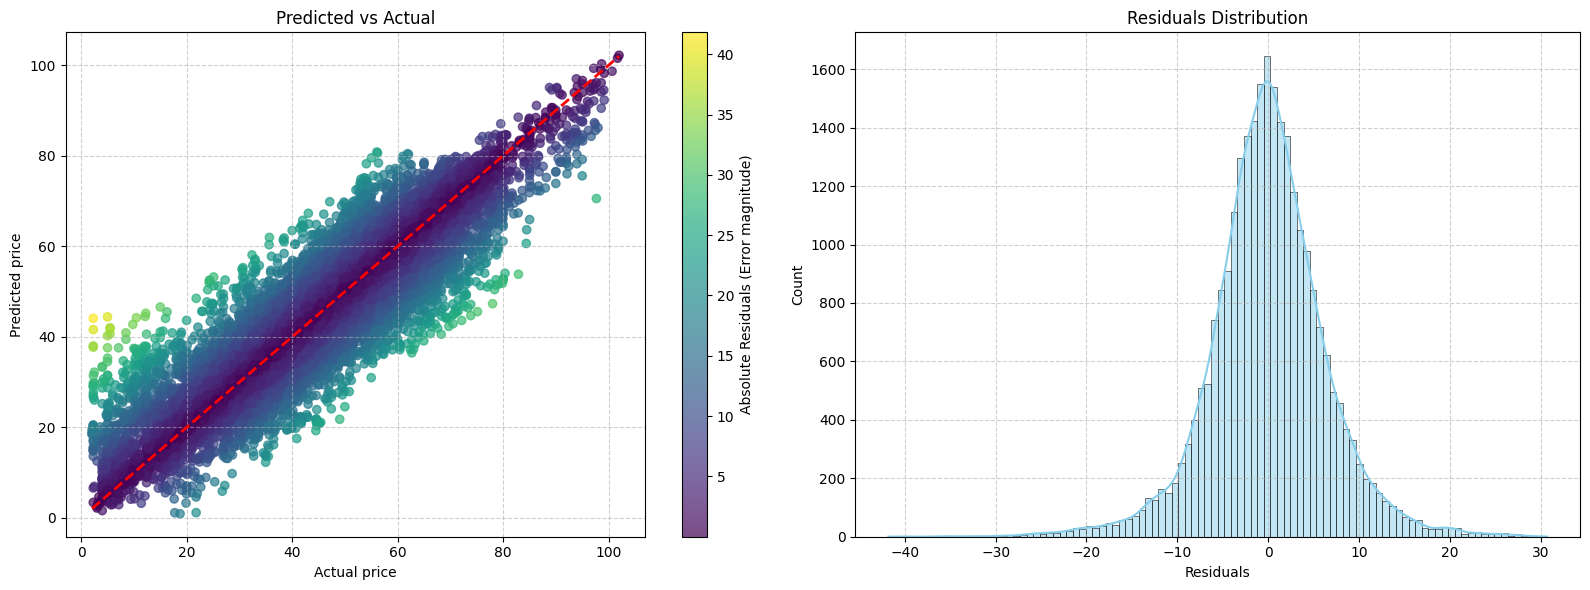

In [19]:

plot_test_results(y_values[start_validation_idx:current_test_end], y_pred_roll)

With the ARIMA residuals correction we were able to extract information left in the residuals and sligthly improve the model performance (Base RMSE: 6.3 -> Corrected: 5.5)

For a final test, we will do the same workflow on testing data we haven't touched yet.

In [20]:

warnings.filterwarnings("ignore")

# Data preparation
common_idx = X_train_final.index.intersection(y_train.index)
X_train_aligned = X_train_final.loc[common_idx]
y_train_aligned = y_train.loc[common_idx]

#we evaluate only on x_test but we have to concat train+test for rolling window
X_full = np.concatenate([X_train_aligned.values, X_test_final.values], axis=0)
y_full = np.concatenate([y_train_aligned.values, y_test.values], axis=0).ravel()


lookback = 720   
horizon = 24    

# here we define where test data starts
test_start_idx = len(X_train_aligned)
total_samples = len(X_full)


steps = (total_samples - test_start_idx) // horizon

print(f"Test start index: {test_start_idx}")
print(f"Total test days: {steps}")
print(f"Lags for Correction: [1, 2, 23]")

y_pred_roll = []
rmse_base_list = []
rmse_final_list = []
actuals_all = [] 

#main loop
for i in tqdm(range(steps)):
    
    # index for prediction
    curr_pred_start = test_start_idx + (i * horizon)
    curr_pred_end = curr_pred_start + horizon
    
    if curr_pred_end > total_samples:
        break

    #index for training
    curr_train_end = curr_pred_start
    curr_train_start = curr_train_end - lookback
    
    # Slicing
    X_tr = X_full[curr_train_start : curr_train_end]
    y_tr = y_full[curr_train_start : curr_train_end]
    
    X_test_batch = X_full[curr_pred_start : curr_pred_end]
    y_test_batch = y_full[curr_pred_start : curr_pred_end]
        
 
    # Impute and scale
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
        
    # Fit on rolling train
    X_tr_sc = scaler.fit_transform(imputer.fit_transform(X_tr))
    
    X_test_sc = scaler.transform(imputer.transform(X_test_batch))
        
    #base model
    base_model = LinearRegression()
    base_model.fit(X_tr_sc, y_tr)
    
    # base model prediction
    base_pred = base_model.predict(X_test_sc)
    
 
    rmse_b = np.sqrt(mean_squared_error(y_test_batch, base_pred))
    rmse_base_list.append(rmse_b)

    
    # residuals on train
    train_pred = base_model.predict(X_tr_sc)
    residuals_train = y_tr - train_pred
    
    try:
      
        # Fit AR model on residuals
        ar_model = AutoReg(residuals_train, lags=[1, 2, 23], old_names=False)
        ar_fit = ar_model.fit()
        
        # forecast correction
        forecast_start = len(residuals_train)
        forecast_end = len(residuals_train) + horizon - 1
        
        correction = ar_fit.predict(start=forecast_start, end=forecast_end, dynamic=False)
        
    except Exception as e:
        correction = np.zeros(horizon)
    
    # final sum
    final_pred = base_pred + correction
    
  
    rmse_f = np.sqrt(mean_squared_error(y_test_batch, final_pred))
    rmse_final_list.append(rmse_f)
    
    y_pred_roll.extend(final_pred)
    actuals_all.extend(y_test_batch)


print("\nTesting set results")
print(f"Average RMSE base model: {np.mean(rmse_base_list):.4f} €/MWh")
print(f"Average RMSE with AR correction: {np.mean(rmse_final_list):.4f} €/MWh")


Test start index: 27971
Total test days: 290
Lags for Correction: [1, 2, 23]


100%|██████████| 290/290 [00:01<00:00, 226.56it/s]


Testing set results
Average RMSE base model: 5.2219 €/MWh
Average RMSE with AR correction: 4.8883 €/MWh


Once again, the residual correction dropped the RMSE from 5.22 to 4.88 €/MWh
Let's also calculate the average error in percentage (MAPE)

In [21]:

mean_price = np.mean(y_test) 
mape_proxy = (np.mean(rmse_final_list) / mean_price) * 100
print(f"Average price: {mean_price:.2f} €")
print(f"Approximate error in percent: {mape_proxy:.1f} %")

Average price: 58.31 €
Approximate error in percent: 8.4 %


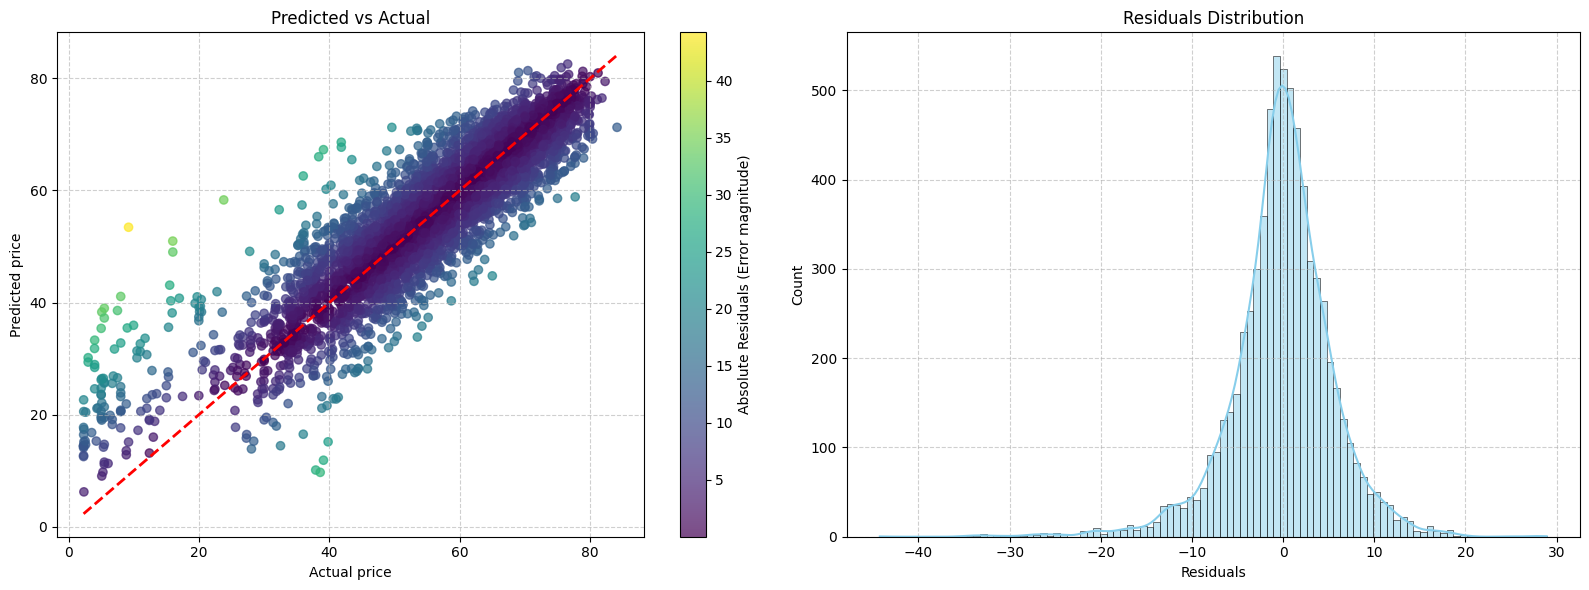

In [22]:
plot_test_results(np.array(actuals_all), np.array(y_pred_roll))

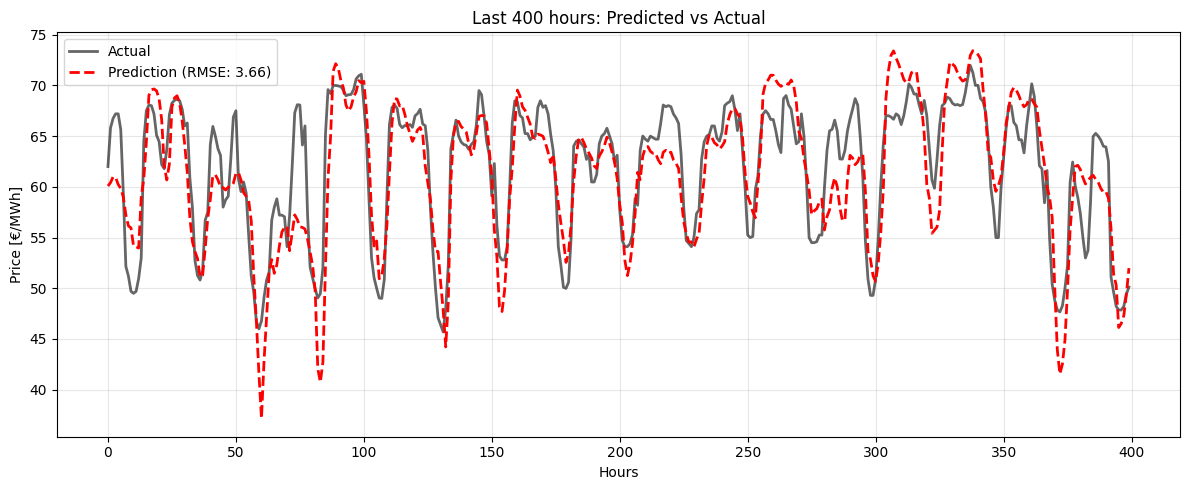

In [23]:

def plot_zoom(y_true, y_pred, n=200):
  
    # get last n values
    act_zoom = np.array(y_true)[-n:]
    pred_zoom = np.array(y_pred)[-n:]
    
    # calculate RMSE just for this section
    local_rmse = np.sqrt(mean_squared_error(act_zoom, pred_zoom))

    
    plt.figure(figsize=(12, 5))    
    plt.plot(act_zoom, label='Actual', color='black', alpha=0.6, linewidth=2)
    plt.plot(pred_zoom, label=f'Prediction (RMSE: {local_rmse:.2f})', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'Last {n} hours: Predicted vs Actual')
    plt.xlabel('Hours')
    plt.ylabel('Price [€/MWh]')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_zoom(actuals_all, y_pred_roll,n=400)

Lets compare this model to naive benchmark, where price today = price yesterday


In [24]:

naive_pred = pd.Series(y_test).shift(24).fillna(method='bfill') 
rmse_naive = np.sqrt(mean_squared_error(y_test, naive_pred))

print(f"Naive Model RMSE: {rmse_naive:.2f}")

Naive Model RMSE: 9.86


## Model performance summary

The table below summarizes the predictive performance of the baseline linear model and the extended model with residual timeseries correction.


| Model | Dataset | RMSE (EUR/MWh) |
|------|--------|----------------|
| Linear Regression (base) | Train | **6.36** |
| Base model + ARIMA residual correction | Train | **5.61** |
| Linear Regression (base) | Test | **5.22** | 
| Base model + ARIMA residual correction | Test | **4.88** | 

The residual correction improves also out of sample performance, indicating that short term autocorrelation not captured by the linear model can be modeled using a stochastic timeseries component.




## Model limitations 
  
### 1. Extreme price spikes

The model struggles to accurately predict extreme price spikes caused by:
- sudden power plant outages
- unexpected transmission constraints

These events are typically not inferable from historical fundamentals alone and represent exogenous shocks rather than market dynamics.


### 2. Dependence on input forecast quality

The model assumes that inputs such as weather forecasts and generation mix estimates are reasonably accurate.

Errors in forecasts propagate directly into price predictions and represent an external source of uncertainty that the model does not explicitly correct for.

### 3. Short term horizon focus

The model is explicitly designed for short-term (day-ahead) forecasting.

It is not suitable for medium or long term price forecasting

---
The goal of this project was not to build a universally optimal predictor, but to understand behavior of non stationary financial markets and find a pipeline for developing a reasonable prediction model.

In next parts of this project, we will also implement XGboost, LSTM and compare the results.